In [ ]:
!pip install openpyxl
!pip install mlxtend
!pip install pyspellchecker
!pip install nltk
!sudo apt install build-essentials
!pip install cyhunspell
!sudo apt-get install hunspell-es

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package build-essentials
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
hunspell-es is already the newest version (1:6.0.3-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import time

In [ ]:
df1= pd.read_excel("obs_asigna_osee.xlsx")
print(df1.shape)
df1.head()

(81488, 5)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin
0,200022,T0000000001,"Ninguna, esta operativa.",97,1
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0
4,200220,T0000000005,La madre vive en Anexo con la Estudiante y no ...,1,0


In [ ]:
# columns = ['oracion','oracion_final_str','sent']
# df = pd.read_csv('oraciones_sentimiento.zip', compression='zip', header=0, sep='\t', quotechar='"', usecols=columns)
# #df.drop({['index','key']})
# print(df.shape)
# df.head()

#1. Delete SW

In [ ]:
import spacy
spacy.prefer_gpu()
spacy.cli.download('es_core_news_md')
nlp = spacy.load('es_core_news_md')

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [ ]:
#Añadiendo nuevos stopwords
#==========================
sw_nuevos = ['rt','tv','https','mineduperu','ja','q','xd', 'iberio','iberia','iberica','jaja','jajajaja','http', 'click', 'clase','ano','escolar']
for sw in sw_nuevos:
    nlp.Defaults.stop_words.add(sw)
    nlp.vocab[sw].is_stop = True
    
#Eliminando Sw x defecto y personalizados
#========================================

def QuitarSwTodos(tokens):
    doc = nlp(str(tokens))
    n_tokens = [token.text for token in doc if not token.is_stop]   

    #lematizando
    #==========    
    cad = ' '.join([str(item) for item in n_tokens])  
    doc = nlp(cad)
    lemas = [tok.lemma_.lower() for tok in doc]
    cad = ' '.join([str(item) for item in lemas])  
    # print('cad',cad) 
    # print('lemas',lemas) 
    return cad

In [ ]:
df1 = df1.head(30000)

df1['oracion_final_str'] = df1['obs'].apply(lambda x: QuitarSwTodos(x))

df = df1.copy()

#2. Spelling Words

In [ ]:
from spellchecker import SpellChecker
import re

spellsp = SpellChecker(language='es', distance=1, case_sensitive= False)

In [ ]:
def clean_html(html):
        # First we remove inline JavaScript/CSS:
    cleaned = re.sub(r"(?is)<(script|style).*?>.*?(</\1>)", "", html.strip())
    # Then we remove html comments. This has to be done before removing regular
    # tags since comments can contain '>' characters.
    cleaned = re.sub(r"(?s)<!--(.*?)-->[\n]?", "", cleaned)
    # Next we can remove the remaining tags:
    cleaned = re.sub(r"(?s)<.*?>", " ", cleaned)
    # Finally, we deal with whitespace
    cleaned = re.sub(r"&nbsp;", " ", cleaned)
    cleaned = re.sub(r"[\r\n]", " ", cleaned)
    cleaned = re.sub(r"[(http(s)?):\/\/(www\.)?a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    cleaned = re.sub(r"  ", " ", cleaned)
    return cleaned.strip()
    raise NotImplementedError ("To remove HTML markup, use BeautifulSoup's get_text() function")
df['oracion_final_str'] = df.oracion_final_str.apply(lambda oracion: clean_html(str(oracion).lower()))
df['oracion_final_str'] = df.oracion_final_str.apply(lambda oracion: re.findall('[a-zA-Záéíóúü]+', oracion))

df['length'] = df.oracion_final_str.apply(lambda oracion: len(oracion))
df = df[df['length']>=3]
print(df.shape)
df.head(3)

(15003, 7)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[ni, o, vivir, abuelo, aurelia, costilla, flor...",10
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignar, tableta, a, estudiante, entregar, es...",6
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vivir, anexo, y, actualizar, dni, moti...",8


In [ ]:
# Corrigiendo palabras mal escritas (Distancia Leveshtein)
#===========================================

df['oracion_corregida']=''
# df = dfo.copy()
for index, row in df.iterrows():
  oracion = row['oracion_final_str']
  lista_palabras = []
  for palabra in oracion:    
    lista_palabras.append(spellsp.correction(palabra))
  # print(lista_palabras)  
  df.at[index,'oracion_corregida'] = lista_palabras
print(df.shape)
df.head(3)

(15003, 8)


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length,oracion_corregida
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[ni, o, vivir, abuelo, aurelia, costilla, flor...",10,"[ni, o, vivir, abuelo, aurelia, costilla, flor..."
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignar, tableta, a, estudiante, entregar, es...",6,"[asignar, tableta, a, estudiante, entregar, es..."
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vivir, anexo, y, actualizar, dni, moti...",8,"[madre, vivir, anexo, y, actualizar, dni, moti..."


In [ ]:
# Quitando palabras que no tienen corrección
#===========================================

from hunspell import Hunspell
h = Hunspell('index', hunspell_data_dir='')
h.spell('orgulloupn')

def EliminarStopWordsHunspell(tokens):
    tks=[]
    for token in tokens:
      if len(token)>1:
        res = h.spell(token)
        if res:
          tks.append(token)
    return tks

In [ ]:
df['oracion_corregida']= df['oracion_corregida'].apply(lambda oracion: EliminarStopWordsHunspell(oracion))
df['length_final'] = df.oracion_corregida.apply(lambda oracion: len(oracion))
df = df[df['length_final']>=2]
df['oracion_corregida'] = df['oracion_corregida'].apply(lambda x: ' '.join([str(item) for item in x]))
print(df.shape)
df.head(5)

(13811, 9)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CODIGO_MODULAR,SERIE_EQUIPO_OSEE,obs,flg_cat,flg_bin,oracion_final_str,length,oracion_corregida,length_final
1,200220,T0000000002,La niña vive con su abuela Aurelia Costilla Fl...,6,1,"[ni, o, vivir, abuelo, aurelia, costilla, flor...",10,ni vivir abuelo costilla flores padre fallecer,7
2,200238,T0000000003,Se asignó la tableta a la estudiante pero aún ...,14,0,"[asignar, tableta, a, estudiante, entregar, es...",6,asignar tableta estudiante entregar estudiante,5
3,200220,T0000000004,La Madre vive en Anexo y no pudo actualizar su...,1,0,"[madre, vivir, anexo, y, actualizar, dni, moti...",8,madre vivir anexo actualizar motivo pandemia,6
4,200220,T0000000005,La madre vive en Anexo con la Estudiante y no ...,1,0,"[madre, vivir, anexo, estudiante, y, validar, ...",8,madre vivir anexo estudiante validar pandemia,6
5,200220,T0000000006,La madre vive en Anexo y no pudo realizar actu...,1,0,"[madre, vivir, anexo, y, actualización, dni, p...",7,madre vivir anexo actualización pandemia,5


In [ ]:
df=df[['obs','oracion_corregida']]
print(df.shape)
df.head(3)

(13811, 2)


,obs,oracion_corregida
1,La niña vive con su abuela Aurelia Costilla Fl...,ni vivir abuelo costilla flores padre fallecer
2,Se asignó la tableta a la estudiante pero aún ...,asignar tableta estudiante entregar estudiante
3,La Madre vive en Anexo y no pudo actualizar su...,madre vivir anexo actualizar motivo pandemia


#3. Creando Matriz Documento-Término CountVectorizer

In [ ]:
tweets = df.oracion_corregida
tweets.head()

1    ni vivir abuelo costilla flores padre fallecer
2    asignar tableta estudiante entregar estudiante
3      madre vivir anexo actualizar motivo pandemia
4     madre vivir anexo estudiante validar pandemia
5          madre vivir anexo actualización pandemia
Name: oracion_corregida, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(tweets)

dtm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
dtm.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abad,abajo,abandonado,abandonar,abandono,abarca,abasto,abertura,abran,abrazan,...,zumba,ángel,ángeles,ángulo,área,átalo,ícono,ítem,única,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
dtm_nw = dtm.applymap(encode_units)
dtm_nw.head()

,abad,abajo,abandonado,abandonar,abandono,abarca,abasto,abertura,abran,abrazan,...,zumba,ángel,ángeles,ángulo,área,átalo,ícono,ítem,única,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#4. Reglas de mínimo soporte

In [ ]:
freq_words = apriori(dtm_nw, min_support=0.02, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)
freq_words['freq'] = freq_words['itemsets'].apply(lambda x: len(x))
freq_words.head()

,support,itemsets,freq
0,0.255593,(tableta),1
1,0.177540,(entregar),1
2,0.152994,(estudiante),1
3,0.098834,(madre),1
4,0.072913,(padre),1


5. Generando reglas y ordenando de acuerdo al Lift

In [ ]:
res = association_rules(freq_words, metric='lift').sort_values('lift', ascending=False).reset_index(drop=True)
res.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(solar),(cargador),0.037651,0.047136,0.031931,0.848077,17.991998,0.030156,6.272014
1,(cargador),(solar),0.047136,0.037651,0.031931,0.677419,17.991998,0.030156,2.983281
2,(formato),(control),0.054739,0.046557,0.034827,0.636243,13.665875,0.032279,2.621101
3,(control),(formato),0.046557,0.054739,0.034827,0.748056,13.665875,0.032279,3.751869
4,(perfecto),(condicionar),0.028456,0.057925,0.020419,0.717557,12.387729,0.018770,3.335455
5,(condicionar),(perfecto),0.057925,0.028456,0.020419,0.352500,12.387729,0.018770,1.500455
6,(condicionar),"(entregar, tableta)",0.057925,0.068713,0.025415,0.438750,6.385223,0.021434,1.659308
7,"(entregar, tableta)",(condicionar),0.068713,0.057925,0.025415,0.369863,6.385223,0.021434,1.495032
8,(madre),(familia),0.098834,0.032655,0.020563,0.208059,6.371391,0.017336,1.221485
9,(familia),(madre),0.032655,0.098834,0.020563,0.629712,6.371391,0.017336,2.433687


In [ ]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         32 non-null     object 
 1   consequents         32 non-null     object 
 2   antecedent support  32 non-null     float64
 3   consequent support  32 non-null     float64
 4   support             32 non-null     float64
 5   confidence          32 non-null     float64
 6   lift                32 non-null     float64
 7   leverage            32 non-null     float64
 8   conviction          32 non-null     float64
dtypes: float64(7), object(2)
memory usage: 2.4+ KB


#5. Convirtiendo en Grafo

In [ ]:
G = nx.from_pandas_edgelist(res, source = 'antecedents', target = 'consequents', create_using=nx.DiGraph(), edge_attr='support')
print(nx.info(G))

DiGraph with 16 nodes and 32 edges


In [ ]:
#Top nodes (valores más altos del diccionario)
def get_top_nodes(cdict, num=10):
  top_nodes ={}
  for i in range(num):
    top_nodes =dict(sorted(cdict.items(), key=lambda x: x[1], reverse=True)[:num])
    return top_nodes

In [ ]:
gdeg=G.degree()

In [ ]:
get_top_nodes(dict(gdeg))

{frozenset({'tableta'}): 12,
 frozenset({'entregar'}): 10,
 frozenset({'condicionar'}): 8,
 frozenset({'estudiante'}): 6,
 frozenset({'madre'}): 4,
 frozenset({'asignar'}): 4,
 frozenset({'solar'}): 2,
 frozenset({'cargador'}): 2,
 frozenset({'formato'}): 2,
 frozenset({'control'}): 2}

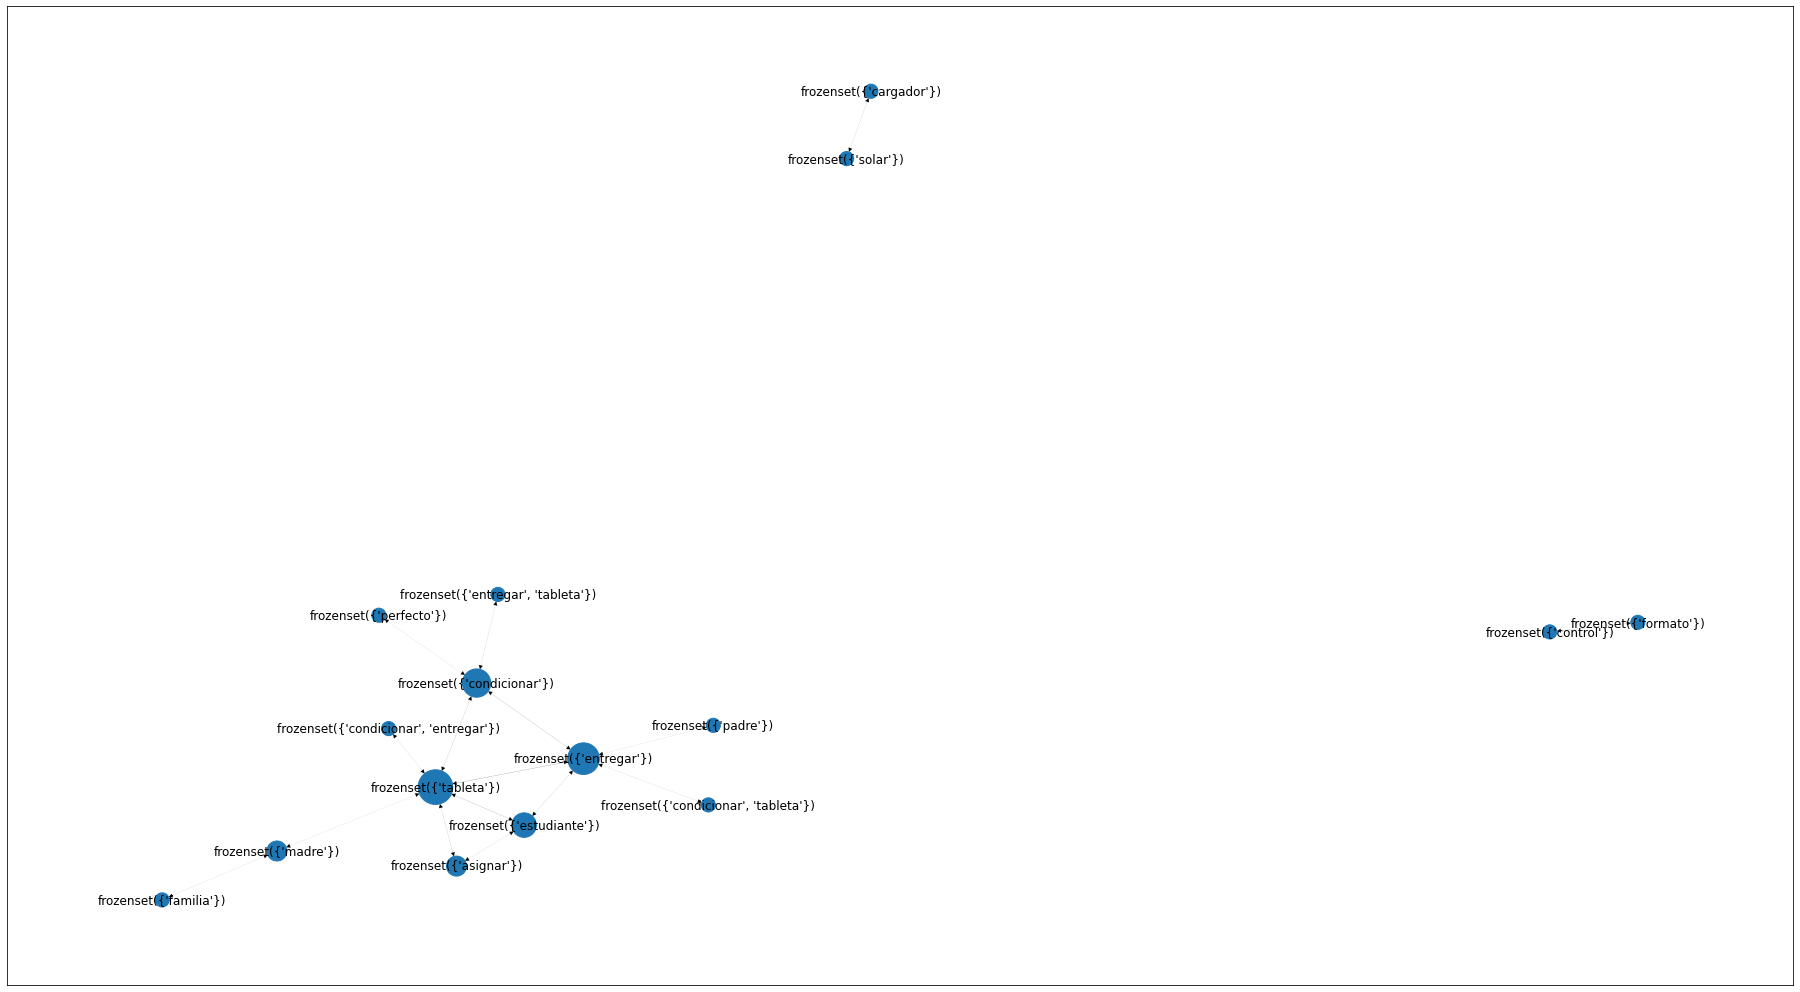

In [ ]:
plt.figure(figsize=(32,18))
edges = G.edges()
weights = [G[u][v]['support'] for u,v in edges]
nx.draw_networkx(G, width=weights, node_size=[100*val for(node,val)in gdeg])
plt.show()